# Modelagem preditiva
_Machine Learning_

---

## Sumário

1. **Importação de bibliotecas**
2. **Carregamento das bases**
    - 2.1. Carregamento dos dataframes
    - 2.2. Extração de amostra dos dataframes
3. **Preparação dos dados**
    - 3.1. Exibição dos metadados
    - 3.2. Preparação das bases de treino e teste
        - 3.2.1. Análise de cardinalidade
        - 3.2.2. Variáveis não aplicáveis à modelagem
        - 3.2.3. Segmentação das bases **train** e **test**
        - 3.2.4. Transformação das features das bases **train** e **test**
4. **Modelagem preditiva**
    - 4.1. Treinamento de N modelos de classificação
    - 4.2. Avaliação dos modelos de classificação
    - 4.3. Avaliação do melhor modelo escolhido
5. **Tunagem dos hiperparâmetros do modelo**
    - 5.1. Tunagem e definição dos melhores hiperparâmetros
    - 5.2. Avaliação do modelo com os melhores hiperparâmetros
    - 5.3. Avaliação do modelo com a alteração de thresholds
6. **Análise e desempenho do modelo com N variáveis**
    - 6.1. Visualização das N variáveis mais importantes
    - 6.2. Avaliação do modelo com N variáveis mais importantes

<br>

---

<br>

## 1. Importação de bibliotecas

In [1]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import optuna

from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from optuna.samplers import TPESampler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, f1_score, auc, roc_curve, roc_auc_score, 
                             confusion_matrix, precision_recall_curve, precision_score, 
                             classification_report, recall_score, average_precision_score,
                             confusion_matrix, ConfusionMatrixDisplay)


In [2]:
# Configurações para exibição de dados no Jupyter Notebook

# Configurar para exibir todas as colunas do Dataframe
pd.set_option('display.max_columns', None)

# Configurar para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supressão de mensagens de aviso durante a execução
warnings.filterwarnings('ignore')

# Configurar o estilo do Seaborn
sns.set_theme(style='whitegrid')

## 2. Carregamento das bases

### 2.1. Carregamento dos dataframes

In [3]:
# Efetuando a limpeza de memória antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da memória: {gc.collect()}')


Quantidade de objetos removidos da memória: 0


In [4]:
# Caminho base
base_path = Path('dados/dados_transformados_parquet/')

# Mapeamento nome_variavel: nome_arquivo
files = {
    'df_train': 'df_train.parquet',
    'df_val': 'df_val.parquet',
    'df_test': 'df_test.parquet'
}

# Carrega os DataFrames no dicionário
temp_dfs = {}
for var_name, file_name in files.items():
    try:
        temp_dfs[var_name] = pd.read_parquet(base_path / file_name)
    except Exception as e:
        print(f'Erro ao carregar {file_name}: {e}')

# Atribui às variáveis explicitamente
df_train_full, df_val_full, df_test_full = [temp_dfs[name] for name in ['df_train', 'df_val', 'df_test']]


In [5]:
# Exibindo da volumetria dos dados

print('\nVOLUMETRIA')
for name, df in temp_dfs.items():
    print(f'\n{name}')
    print('-' * 45)
    print(f'Quantidade de linhas (registros):  {df.shape[0]:,}')
    print(f'Quantidade de colunas (variáveis): {df.shape[1]:,}')



VOLUMETRIA

df_train
---------------------------------------------
Quantidade de linhas (registros):  3,566,068
Quantidade de colunas (variáveis): 157

df_val
---------------------------------------------
Quantidade de linhas (registros):  891,518
Quantidade de colunas (variáveis): 157

df_test
---------------------------------------------
Quantidade de linhas (registros):  2,194,300
Quantidade de colunas (variáveis): 157


### 2.2. Extração de amostra dos dataframes

In [6]:
# Função para geração de uma amostra estratificada de um DataFrame

def stratified_sample_classification(df, y_col, frac):
    '''
    Retorna uma amostra estratificada de um DataFrame com base na variável-alvo 
    mantendo a proporção original das classes.

    :param df: DataFrame
        DataFrame contendo as features e a variável-alvo.
    :param y_col: str
        Nome da coluna correspondente à variável-alvo (classe).
    :param frac: float
        Fração (entre 0 e 1) de registros a serem amostrados.
    :return: DataFrame
        Subconjunto amostrado do DataFrame original.
    '''
    sample_df, _ = train_test_split(
        df,
        train_size=frac,
        stratify=df[y_col],
        random_state=42
    )

    return sample_df

In [7]:
# Nome da variável-alvo
y_col = 'is_fraud'

# Fração desejada
frac = 0.25

# Gerando amostras estratificadas e uma amostra aleatória
df_train = stratified_sample_classification(df_train_full, y_col, frac)
df_val   = stratified_sample_classification(df_val_full, y_col, frac)
df_test  = df_test_full.sample(frac=frac, random_state=42)

In [8]:
# Comparativo dos tamanhos dos DataFrames originais e amostrados
print(f'       Original → Amostra')
print(f'Train: {len(df_train_full)}  → {len(df_train)}')
print(f'Val:   {len(df_val_full)}   → {len(df_val)}')
print(f'Test:  {len(df_test_full)}  → {len(df_test)}')

       Original → Amostra
Train: 3566068  → 891517
Val:   891518   → 222879
Test:  2194300  → 548575


## 3. Preparação dos dados

### 3.1. Exibição dos metadados

In [9]:
# Função para geração de um dataframe de metadados

def generate_metadata(dataframe):
    '''
    Gera um DataFrame contendo metadados das colunas do DataFrame fornecido.

    :param dataframe: DataFrame
        DataFrame para o qual os metadados serão gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadata = pd.DataFrame({
        'Variável': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'Cardinalidade': dataframe.nunique(),
    }).sort_values(by='Qtde de nulos', ascending=False).reset_index(drop=True)

    return metadata


In [10]:
# Exibe todas as linhas temporariamente

with pd.option_context('display.max_rows', None):
    display(generate_metadata(df_train))


,Variável,Tipo,Qtde de nulos,% de nulos,Cardinalidade
0,errors,object,877190,98.39,19
1,card_std_last_1h,float64,832500,93.38,32418
2,card_std_last_2h,float64,814406,91.35,40425
3,client_std_last_1h,float64,802096,89.97,44237
4,card_std_last_4h,float64,784767,88.03,52274
5,client_std_last_2h,float64,765354,85.85,58816
6,card_std_last_8h,float64,737993,82.78,71303
7,client_std_last_4h,float64,707408,79.35,82753
8,card_std_last_12h,float64,702581,78.81,87348
9,client_std_last_8h,float64,620469,69.60,125283


### 3.2. Preparação das bases de treino e teste

#### 3.2.1. Análise de cardinalidade

In [11]:
# Listando variáveis com determinado valor de cardinalidade

def list_low_cardinality_columns(dataframe, threshold=2):
    '''
    Lista os nomes das colunas de um DataFrame com cardinalidade inferior a um valor dado.

    :param dataframe: pd.DataFrame
        DataFrame a ser analisado.
    :param threshold: int
        Valor de corte para cardinalidade. Default é 2.
    :return: list
        Lista com os nomes das colunas cuja cardinalidade é menor que o threshold.
    '''
    return [col for col in dataframe.columns if dataframe[col].nunique(dropna=False) < threshold]


In [12]:
print('df_train - variáveis com baixa cardinalidade:\n', list_low_cardinality_columns(df_train))
print('\ndf_val - variáveis com baixa cardinalidade:\n', list_low_cardinality_columns(df_val))
print('\ndf_test - variáveis com baixa cardinalidade:\n', list_low_cardinality_columns(df_test))

df_train - variáveis com baixa cardinalidade:
 ['card_on_dark_web', 'flag_risky_chip_use', 'flag_no_chip_darkweb']

df_val - variáveis com baixa cardinalidade:
 ['card_on_dark_web', 'flag_risky_chip_use', 'flag_no_chip_darkweb']

df_test - variáveis com baixa cardinalidade:
 ['card_on_dark_web', 'transaction_id', 'is_fraud', 'flag_risky_chip_use', 'flag_no_chip_darkweb']


#### 3.2.2. Variáveis não aplicáveis à modelagem

In [13]:
# Lista as features de um DataFrame que contêm o termo 'id' no nome.

def list_columns_with_id(dataframe, case_sensitive=False):
    '''
    Lista os nomes das colunas de um DataFrame que contêm 'id' no nome.

    :param dataframe: pd.DataFrame
        DataFrame a ser analisado.
    :param case_sensitive: bool
        Se True, diferencia maiúsculas de minúsculas. Default é False.
    :return: list
        Lista com os nomes das colunas que contêm 'id'.
    '''
    if case_sensitive:
        return [col for col in dataframe.columns if 'id' in col]
    else:
        return [col for col in dataframe.columns if 'id' in col.lower()]


In [14]:
print('df_train - variáveis com termo "id":\n', list_columns_with_id(df_train))
print('\ndf_val - variáveis com termo "id":\n', list_columns_with_id(df_val))
print('\ndf_test - variáveis com termo "id":\n', list_columns_with_id(df_test))

df_train - variáveis com termo "id":
 ['id', 'client_id', 'card_id', 'merchant_id', 'id_card', 'client_id_card', 'id_client', 'transaction_id', 'merchant_id_is_new']

df_val - variáveis com termo "id":
 ['id', 'client_id', 'card_id', 'merchant_id', 'id_card', 'client_id_card', 'id_client', 'transaction_id', 'merchant_id_is_new']

df_test - variáveis com termo "id":
 ['id', 'client_id', 'card_id', 'merchant_id', 'id_card', 'client_id_card', 'id_client', 'transaction_id', 'merchant_id_is_new']


In [15]:
# Criando conjunto de variáveis que serão removidas dos DataFrames

vars_to_remove = ['zip', 'date', 'expires', 'acct_open_date']
vars_to_remove = vars_to_remove + ['id', 'client_id', 'card_id', 'merchant_id', 'id_card', 'client_id_card', 
                  'id_client', 'transaction_id', 'merchant_id_is_new','card_on_dark_web', 
                  'flag_risky_chip_use', 'flag_no_chip_darkweb']

#### 3.2.3. Segmentação das bases **train** e **test**

In [16]:
# Separando as variáveis preditivas e a variável preditora (alvo)

features = df_train.columns.drop('is_fraud')
features = features.drop(vars_to_remove, errors='ignore')
target = 'is_fraud'

In [17]:
# Separando as variáveis numéricas e categóricas

numerical_features = df_train[features].select_dtypes(exclude=[object, 'category']).columns
categorical_features = df_train[features].select_dtypes(include=[object, 'category']).columns

In [18]:
# Converter todas as colunas categóricas para string

df_train[categorical_features] = df_train[categorical_features].astype(str)
df_val[categorical_features] = df_val[categorical_features].astype(str)
df_test[categorical_features] = df_test[categorical_features].astype(str)

In [19]:
# Removendo as variáveis dos DataFrames de treino e teste

X_train = df_train[features]
y_train = df_train[target]

X_test = df_val[features]
y_test = df_val[target]

In [20]:
# Convertendo a variável alvo para numérica

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#### 3.2.4. Transformação das features das bases **train** e **test**

In [21]:
# Criando o pipeline para as variáveis numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as variáveis categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder())
])

In [22]:
# Criando o pipeline de pré-processamento que aplica transformações

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numerical_features)
])
preprocessor = Pipeline(steps=[('preprocessor', preprocessor)])

In [23]:
# Verificando os shapes antes da transformação

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (891517, 140), y_train: (891517,)
Shape: X_test:  (222879, 140),  y_test: (222879,)


In [24]:
# Aplicando o pré-processamento nos conjuntos de treino e teste

X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

In [25]:
# Verificando os shapes após transformação

print(f'Shape de X_train após transformação: {X_train_processed.shape}')
print(f'Shape de X_test após transformação:  {X_test_processed.shape}')

Shape de X_train após transformação: (891517, 140)
Shape de X_test após transformação:  (222879, 140)


## 4. Modelagem preditiva

### 4.1. Treinamento de N modelos de classificação

In [26]:
# Algoritmos de classificação a serem testados com o mínimo de parâmetros

algorithms = {
    'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced', criterion='gini', random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBClassifier': XGBClassifier(eval_metric='logloss', verbosity=0, random_state=42, n_jobs=-1),
    'LGBMClassifier': LGBMClassifier(is_unbalance=True, verbosity=-1, random_state=42, n_jobs=-1)
}  

In [27]:
def calculate_metrics(models, X_train, y_train, X_test, y_test, preprocessor):
    '''
    Calcula e exibe as métricas de desempenho dos modelos fornecidos.

    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino.
    :param y_train: np.ndarray
        Rótulos do conjunto de dados de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste.
    :param y_test: np.ndarray
        Rótulos do conjunto de dados de teste.
    :param preprocessor: Pipeline
        Pipeline de pré-processamento a ser aplicado aos dados.
    '''
    rows = []

    for name, model in models.items():
        
        # Cria um pipeline que inclui o pré-processamento e o modelo
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Registra o tempo de início de treinamento
        start_time = time.time()
        
        # Treina o modelo e faz previsões
        pipeline.fit(X_train, y_train)
        
        # Registra o tempo de duração do treinamento
        elapsed_time = time.time() - start_time
        
        # Itera sobre os conjuntos de treino e teste para calcular as métricas
        for dataset_name, X, y_true in [('Treino', X_train, y_train), ('Teste', X_test, y_test)]:
            # Faz previsões no conjunto atual
            y_pred = pipeline.predict(X)
            y_proba = pipeline.predict_proba(X)[:, 1]
            
            # Métrica KS: compara distribuições das probabilidades para as duas classes
            ks_stat = ks_2samp(y_proba[y_true == 1], y_proba[y_true == 0]).statistic

            # Métrica Gini: 2 * AUC - 1
            auc = roc_auc_score(y_true, y_proba)
            gini = 2 * auc - 1
            
            # Calcula as métricas de desempenho
            rows.append({
                'Algoritmo': name,# if dataset_name == 'Treino' else '',
                'Conjunto': dataset_name,
                'Acurácia': accuracy_score(y_true, y_pred),
                'Precisão': precision_score(y_true, y_pred, zero_division=0),
                'Recall': recall_score(y_true, y_pred),
                'F1-Score': f1_score(y_true, y_pred),
                'ROC AUC': auc, #roc_auc_score(y_true, y_proba),
                'PR AUC': average_precision_score(y_true, y_proba),
                'KS': ks_stat,
                'Gini': gini,
                'Tempo (s)': elapsed_time if dataset_name == 'Treino' else ''
            })
                     
    # Cria o DataFrame final com os resultados
    results_df = pd.DataFrame(rows)
    
    return results_df

In [28]:
# Avaliando os modelos
results_df = calculate_metrics(algorithms, X_train, y_train, X_test, y_test, preprocessor)

# Exibindo os resultados
results_df

,Algoritmo,Conjunto,Acurácia,Precisão,Recall,F1-Score,ROC AUC,PR AUC,KS,Gini,Tempo (s)
0,DecisionTreeClassifier,Treino,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,103.977382
1,DecisionTreeClassifier,Teste,0.998273,0.393574,0.295181,0.337349,0.647251,0.117225,0.294502,0.294502,
2,LogisticRegression,Treino,0.947915,0.026296,0.942771,0.051166,0.984497,0.302400,0.895845,0.968994,61.600852
3,LogisticRegression,Teste,0.942484,0.023361,0.921687,0.045566,0.971917,0.234536,0.866058,0.943835,
4,RandomForestClassifier,Treino,0.999998,1.000000,0.998494,0.999246,1.000000,1.000000,1.000000,1.000000,159.846387
5,RandomForestClassifier,Teste,0.998560,1.000000,0.033133,0.064140,0.922112,0.459434,0.822852,0.844224,
6,XGBClassifier,Treino,0.999962,0.996166,0.978163,0.987082,0.993238,0.985948,0.985198,0.986477,29.130529
7,XGBClassifier,Teste,0.998291,0.437975,0.521084,0.475928,0.955144,0.371101,0.847158,0.910289,
8,LGBMClassifier,Treino,0.958633,0.034026,0.977410,0.065763,0.967499,0.033292,0.936016,0.934999,22.630799
9,LGBMClassifier,Teste,0.947622,0.022964,0.822289,0.044681,0.884867,0.019148,0.770098,0.769734,


### 4.2. Avaliação dos modelos de classificação

In [29]:
def plot_metrics(results_df):
    '''
    Plota as métricas de desempenho dos modelos em subplots.

    :param results_df: DataFrame
        DataFrame contendo as colunas ['Algoritmo', 'Conjunto', <métricas...>] com os resultados
        de avaliação dos modelos para treino e teste.
    '''

    # Verifica colunas obrigatórias
    expected_columns = {'Algoritmo', 'Conjunto'}
    if not expected_columns.issubset(results_df.columns):
        raise ValueError(f'O DataFrame deve conter as colunas: {expected_columns}')

    # Define as métricas a serem plotadas
    metric_columns = ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC', 'KS', 'Gini', 'Tempo (s)']
    for metric in metric_columns:
        if metric not in results_df.columns:
            raise ValueError(f'Métrica {metric} não foi encontrada no DataFrame.')

    # Figura
    fig, axes = plt.subplots(5, 2, figsize=(16, 18))
    fig.suptitle('Métricas de Desempenho dos Modelos', fontsize=18, y=0.93, fontweight='bold')

    # Geração dos gráficos
    for ax, metric in zip(axes.flatten(), metric_columns):
        sns.barplot(
            data=results_df,
            x='Algoritmo',
            y=metric,
            hue='Conjunto',
            palette=['#61b3ef', '#f39e53'],
            dodge=True,
            ax=ax,
        )
        ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=10)
        ax.set_title(metric, fontsize=14)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if metric == 'Tempo (s)':
            max_tempo = results_df[metric].max()
            ax.set_ylim(0, max_tempo * 1.1)  # Dá um pouco de espaço acima do maior valor
        else:
            ax.set_ylim(0, 1.1)  # Ajusta escala padrão para métricas entre 0 e 1
        ax.legend_.remove()

        # Adiciona os valores nas barras
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=10)
            
    # Remove o último eixo (o 10º subplot)
    axes.flatten()[-1].set_visible(False)

    # Legenda global no topo
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title='Conjunto', loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.99))

    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    plt.show()

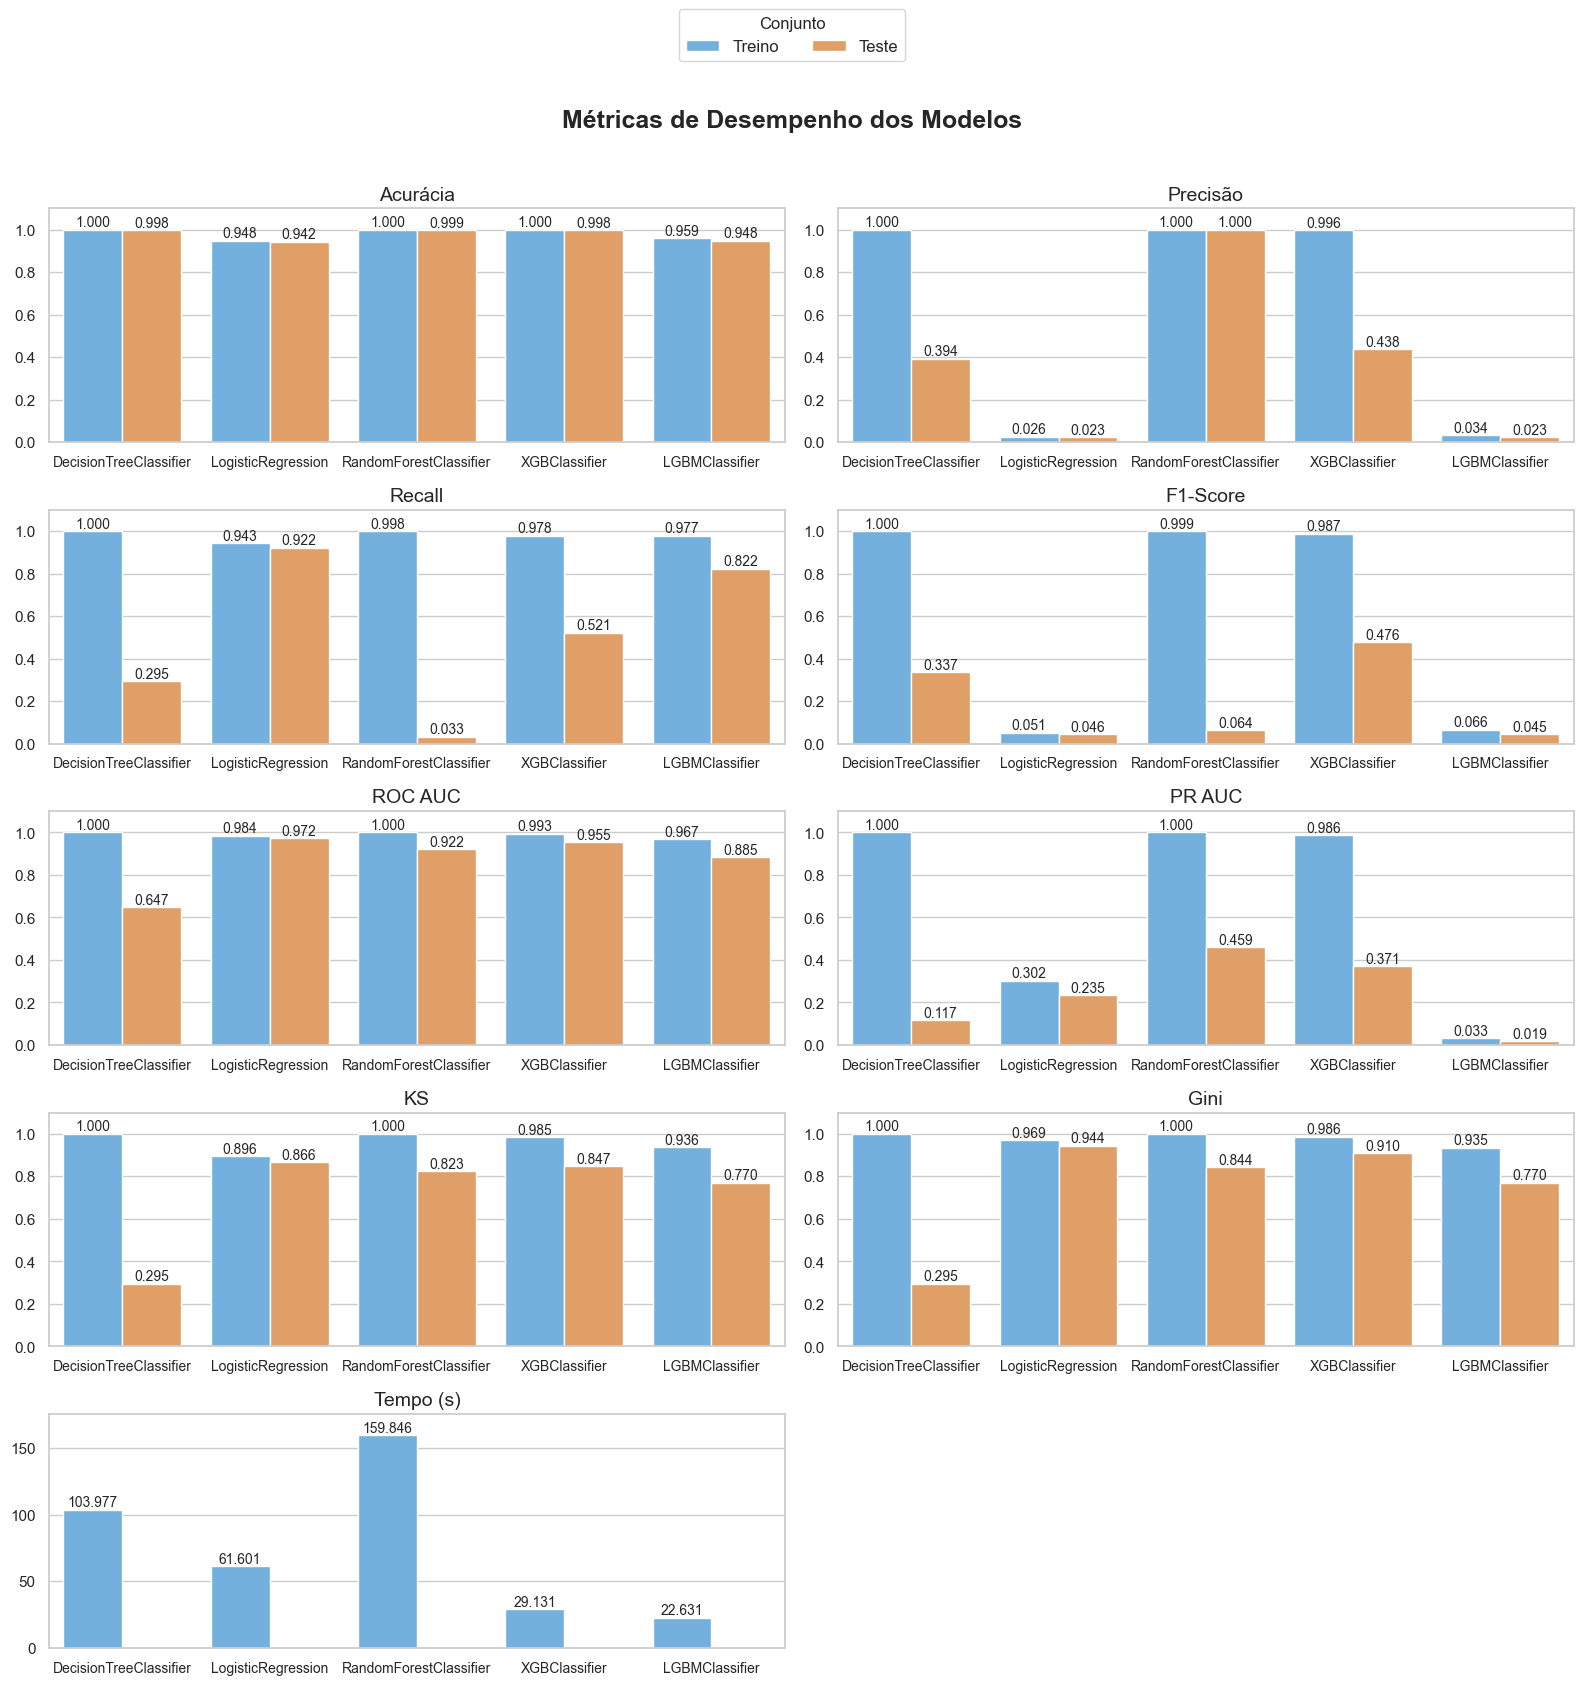

In [30]:
# Garante que 'Tempo (s)' seja numérico
results_df['Tempo (s)'] = pd.to_numeric(results_df['Tempo (s)'], errors='coerce')

# Plota as métricas de desempenho dos modelos
plot_metrics(results_df)

O modelo aplicado ao problema de detecção de fraudes em transações financeiras precisa ser capaz de diferenciar com precisão transações legítimas de fraudulentas. Para isso, foram testados cinco algoritmos de classificação supervisionada, todos com parametrização mínima e com foco em tratar a natureza desbalanceada dos dados, onde a classe _"fraude"_ é rara e representa uma pequena fração das transações. Para medir a performance dos modelos, foram utilizadas 9 métricas de avaliação, sendo que algumas merecem destaque especial, como **Precisão**, **Recall**, **F1-Score** e **PR AUC**, por refletirem melhor o desempenho em cenários de classes desbalanceadas.

- **Acurácia (Accuracy)**: Mede a proporção total de acertos entre todas as previsões (tanto fraudes quanto não fraudes). Apesar de todos os modelos apresentarem acurácia superior a 94%, essa métrica não é confiável neste cenário, pois um modelo que simplesmente preve _"não fraude"_ para todas as transações já teria uma acurácia alta, sendo assim não detectaria nenhuma fraude real.

- **Precisão (Precision)**: Esta métrica mede quantas das transações classificadas como _"fraude"_ realmente são fraudes. Em termos práticos, quanto maior a precisão, menor o risco de falsos positivos, ou seja, de bloquear transações legítimas. O modelo XGBoost foi o único a apresentar boa precisão sem indícios claros de overfitting ou underfitting.

- **Recall (Sensibilidade)**: Indica a proporção de fraudes reais que o modelo conseguiu identificar. Quanto maior o _recall_, maior a capacidade do modelo de detectar fraudes verdadeiras, sendo portanto uma das métricas mais relevantes neste contexto de negócio. Modelos como Regressão Logística, XGBoost e LightGBM tiveram bom desempenho nessa métrica.

- **F1-Score**: Combina precisão e recall numa média harmônica, equilibrando os dois aspectos. Útil para avaliar se o modelo está tanto identificando fraudes quanto sendo preciso nas detecções. O modelo XGBoost apresentou o _F1-Score_ mais consistente, indicando equilíbrio entre as duas métricas.

- **ROC AUC (Área sob a Curva ROC)**: Mede a capacidade do modelo em separar classes, ou seja, prever corretamente fraudes e não fraudes. Embora seja uma métrica comum, pode ser enganosa em casos com classes muito desbalanceadas, pois considera a performance sobre a classe majoritária. Por isso, não é a melhor escolha isoladamente neste cenário de forte desbalanceamento de classes.

- **PR AUC (Área sob a Curva Precisão vs. Recall)**: Essa é a métrica mais recomendada para problemas de fraudes, pois avalia a relação entre as métricas _precisão_ e _recall_ com maior sensibilidade ao desbalanceamento de classes. O XGBoost se destacou novamente, se comparado com os demais modelos, enquanto o RandomForest mostrou overfitting, com ótimo desempenho em treino, mas pior em teste.

- **KS (Kolmogorov-Smirnov)**: Mede a distância máxima entre as distribuições de pontuação das classes positiva (fraude) e negativa (não fraude). Quanto maior o valor de KS, melhor o modelo em separar as duas classes. Modelos como Regressão Logística, XGBoost e LightGBM apresentaram valores consistentes e semelhantes nos conjuntos de treino e teste.

- **Gini**: Derivada da ROC AUC, a métrica Gini mede o poder de discriminação do modelo (quanto maior, melhor). Muito usada em contextos bancários e regulatórios. Modelos com Gini acima de 0.6 já são considerados bons para esse tipo de tarefa. Partindo dessa premissa apenas Regressão Logística, XGBoost e LightGBM apresentaram bom desempenho.

- **Tempo (s)**: Refere-se ao tempo necessário para treinar e aplicar o modelo. Em aplicações reais, esse tempo precisa ser rápido o suficiente para garantir fluidez nas validações de transações. Nesse quesito os modelos XGBoost e LightGBM apresentaram os melhores tempos de execução, sendo viáveis para aplicações em produção.

Ao combinar essas métricas, foi possível identificar que o modelo como **XGBoost** teve o melhor equilíbrio entre performance e robustez. Além disso, a análise das métricas, principalmente **Precisão**, **Recall**, **F1-Score** e **PR AUC**, permitiu avaliar corretamente a efetividade dos modelos no contexto do problema, focando na detecção eficaz de fraudes reais, com controle de falsos positivos.

### 4.3. Avaliação do melhor modelo escolhido

In [31]:
def plot_metrics(model, X_train, y_train, X_test, y_test, features, top_n_features=15):
    '''
    Gera visualizações de avaliação de desempenho de um modelo de classificação binária.

    :param model: estimator
        Estimador do scikit-learn previamente treinado.
    :param X_train: DataFrame
        Conjunto de dados de treino.
    :param y_train: np.ndarray
        Rótulos do conjunto de dados de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste.
    :param y_test: np.ndarray
        Rótulos do conjunto de dados de teste.
    :param features: list or np.ndarray
        Lista ou array contendo os nomes das variáveis preditoras.
    :param top_n_features: int, default=10
        Número de variáveis mais importantes a serem exibidas.
    '''
    
    plt.figure(figsize=(16, 24))
    colors = ['#61b3ef', '#f39e53']
    cmap_custom = LinearSegmentedColormap.from_list("custom_blues", ['#e8f4fd', '#61b3ef'])

    # --- 1. Distribuição de Evento e Não Evento ---
    plt.subplot(5, 2, 1)
    event_rate = y_train.mean()
    values = [1 - event_rate, event_rate]
    labels = ['Não evento', 'Evento']

    ax = sns.barplot(y=labels, x=values, palette=colors)
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.2%}', (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, fontweight='bold',
                    color='black', xytext=(5, 0), textcoords='offset points')
    plt.xlabel('\nProporção', fontsize=12)
    plt.title('Taxa de Evento/Não evento', fontsize=14, fontweight='bold')
    ax.set_xlim(0, max(values) + 0.1)
    sns.despine()
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # --- 2. Importância das Variáveis ---
    plt.subplot(5, 2, 2)
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_).flatten()
        else:
            raise AttributeError('Modelo não possui "feature_importances_" nem "coef_".')
        
        indices = np.argsort(importances)[::-1][:top_n_features]
        ax = sns.barplot(y=np.array(features)[indices], x=importances[indices], color=colors[0])
        plt.xlabel('\nImportância', fontsize=12)
        plt.title('Importância das variáveis', fontsize=14, fontweight='bold')
        sns.despine()
        plt.grid(axis='x', linestyle='--', alpha=0.7)
    except Exception as e:
        plt.text(0.5, 0.5, f'Erro ao calcular importância:\n{e}', ha='center')
        plt.axis('off')

    # --- 3. Curva ROC-AUC ---
    plt.subplot(5, 2, 3)
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]):
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color=colors[i], linewidth=2)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1.2)
    plt.xlabel('\nTaxa de Falsos Positivos (FPR)', fontsize=10)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)\n', fontsize=10)
    plt.title('Curva ROC-AUC', fontsize=12, fontweight='bold')
    plt.legend(loc='lower right', frameon=True, framealpha=0.9, edgecolor='gray')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine()

    # --- 4. Curva Precision-Recall ---
    plt.subplot(5, 2, 4)
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    ap_score = average_precision_score(y_test, y_probs)
    plt.plot(recall, precision, color=colors[1], lw=2, label=f'Precisão Média (AP) = {ap_score:.2f}')
    plt.fill_between(recall, precision, alpha=0.1, color=colors[1])
    plt.title('Curva Precision-Recall', fontsize=14, fontweight='bold')
    plt.xlabel('\nRecall', fontsize=12)
    plt.ylabel('Precision\n', fontsize=12)
    plt.xlim(0, 1.0)
    plt.ylim(0, 1.05)
    plt.legend(loc='lower left', frameon=True, framealpha=0.9, edgecolor='gray')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine()

    # --- 5 e 6. Matrizes de Confusão ---
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], start=5):
        plt.subplot(5, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap_custom,
                    cbar_kws={'label': ''}, linewidths=0.5,
                    linecolor='gray', square=True)
        plt.xlabel('\nClasse Predita', fontsize=10)
        plt.ylabel('Classe Real\n', fontsize=10)
        plt.title(f'Matriz de Confusão - {label}', fontsize=12, fontweight='bold')
        plt.xticks(ticks=[0.5, 1.5], labels=['Não Evento', 'Evento'])
        plt.yticks(ticks=[0.5, 1.5], labels=['Não Evento', 'Evento'], rotation=0)

    # --- 7. KS e Gini ---
    metrics_data = []
    for dataset_name, X, y_true in [('Treino', X_train, y_train), ('Teste', X_test, y_test)]:
        y_proba = model.predict_proba(X)[:, 1]
        ks_stat = ks_2samp(y_proba[y_true == 1], y_proba[y_true == 0]).statistic
        auc_score = roc_auc_score(y_true, y_proba)
        gini = 2 * auc_score - 1
        metrics_data.extend([
            {'Dataset': dataset_name, 'Métrica': 'KS', 'Valor': ks_stat},
            {'Dataset': dataset_name, 'Métrica': 'Gini', 'Valor': gini}
        ])
    df_metrics = pd.DataFrame(metrics_data)

    plt.subplot(5, 2, 7)
    ax = sns.barplot(data=df_metrics, x='Métrica', y='Valor', hue='Dataset', palette=colors)
    for p in ax.patches:
        valor = p.get_height()
        if valor == 0:
            continue  # pula valores nulos
        ax.annotate(f'{valor:.2f}', (p.get_x() + p.get_width() / 2, valor),
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.title('Métricas KS e Gini', fontsize=12, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Valor da Métrica\n', fontsize=10)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks([0, 1], ['KS', 'Gini'])  # Ajustando manualmente os rótulos do eixo X
    sns.despine()
    
    # --- 8. Gráfico do Precision e Recall vs. Limiar ---
    plt.subplot(5, 2, 8)
    precisions, recalls, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(thresholds, precisions[:-1], label='Precision', color=colors[0], lw=2)
    plt.plot(thresholds, recalls[:-1], label='Recall', color=colors[1], lw=2)
    plt.title('Precision e Recall vs. Limiar de Decisão', fontsize=12, fontweight='bold')
    plt.xlabel('\nLimiar de Decisão')
    plt.ylabel('Valor da Métrica\n')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    sns.despine()

    # --- 9. Distribuição dos Scores por Classe (Treino) ---
    plt.subplot(5, 2, 9)    
    fraude_scores = model.predict_proba(X_train)[:, 1][y_train == 1]
    nao_fraude_scores = model.predict_proba(X_train)[:, 1][y_train == 0]
    sns.kdeplot(nao_fraude_scores, label='Não Fraude', color=colors[0], shade=True)
    sns.kdeplot(fraude_scores, label='Fraude', color=colors[1], shade=True)
    plt.title('Distribuição dos Scores por Classe - Treino', fontsize=12, fontweight='bold')
    plt.xlabel('Score de Fraude')
    plt.ylabel('Densidade')
    plt.legend(loc='upper center')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine()

    # --- 10. Distribuição dos Scores por Classe (Teste) ---
    plt.subplot(5, 2, 10)    
    fraude_scores = model.predict_proba(X_test)[:, 1][y_test == 1]
    nao_fraude_scores = model.predict_proba(X_test)[:, 1][y_test == 0]
    sns.kdeplot(nao_fraude_scores, label='Não Fraude', color=colors[0], shade=True)
    sns.kdeplot(fraude_scores, label='Fraude', color=colors[1], shade=True)
    plt.title('Distribuição dos Scores por Classe - Teste', fontsize=12, fontweight='bold')
    plt.xlabel('Score de Fraude')
    plt.ylabel('Densidade')
    plt.legend(loc='upper center')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine()

    # --- Layout Final ---
    plt.suptitle('Análise de Desempenho do Modelo de Classificação',
                fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


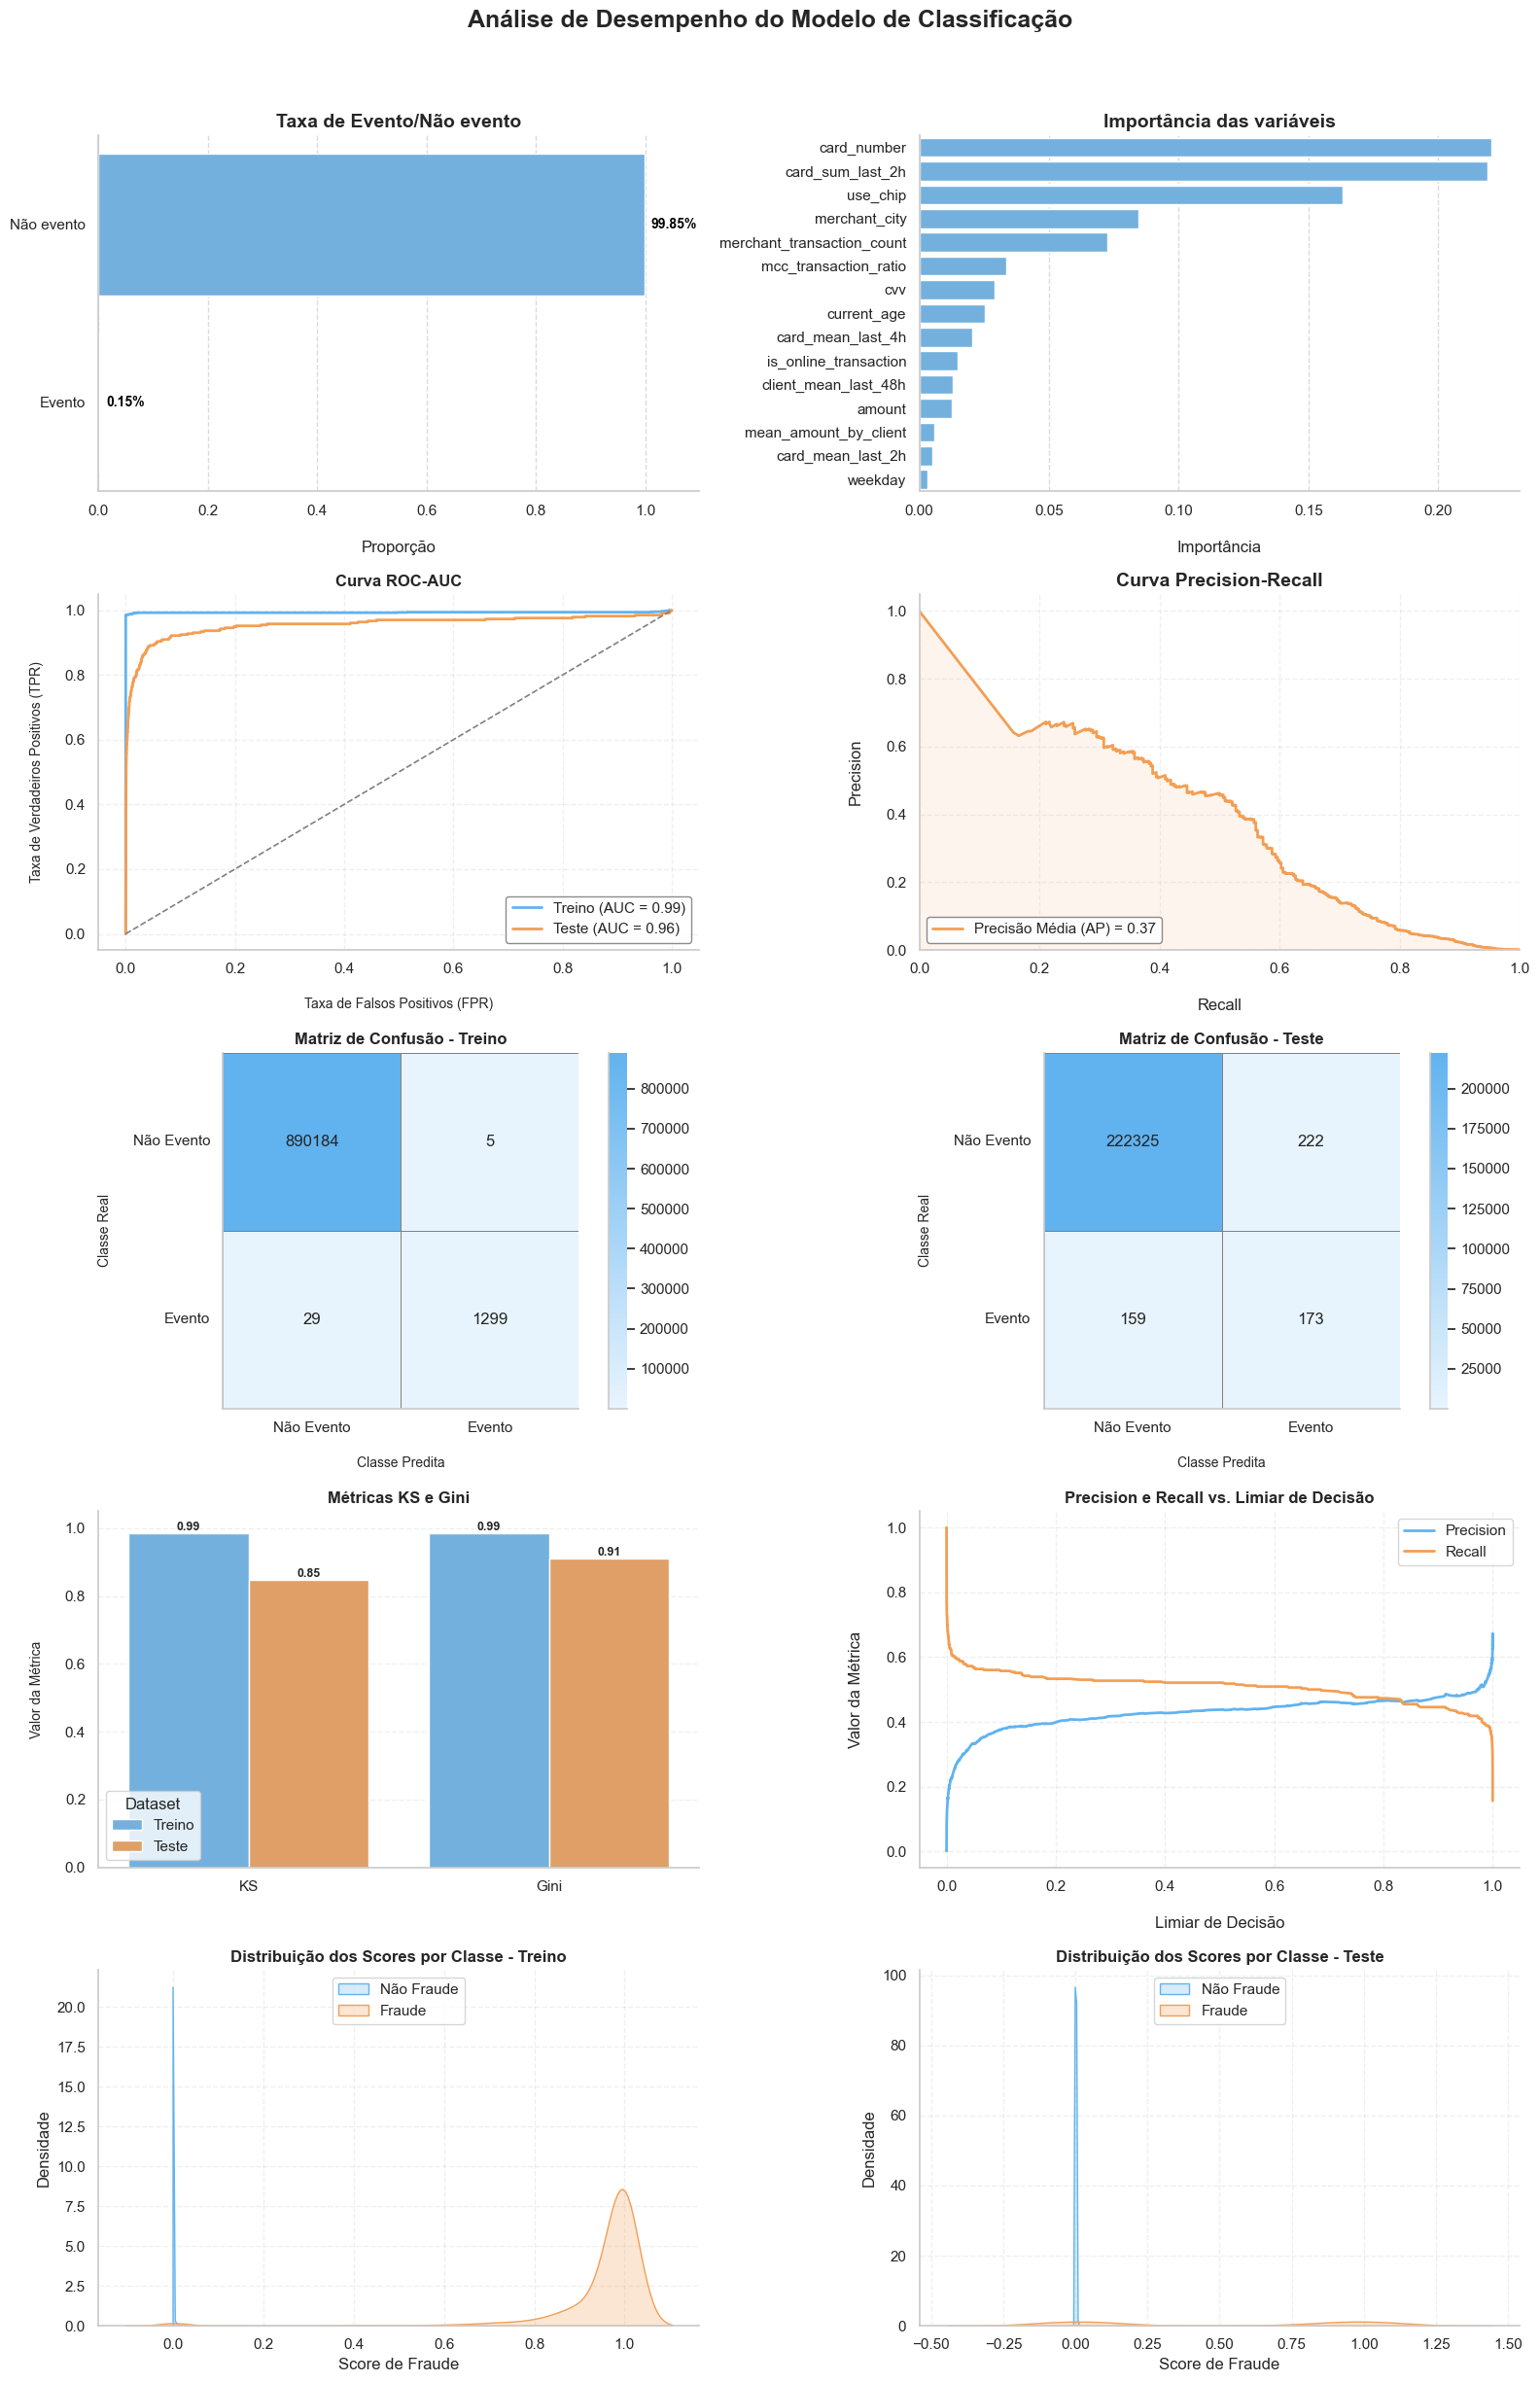

In [32]:
# Obtém os nomes das features
features = X_train.columns

# Treinando o melhor modelo com os dados de treino
best_algorithm = XGBClassifier(eval_metric='logloss', verbosity=0, random_state=42, n_jobs=-1)

# Treinando o modelo com os dados já pré-processados
best_algorithm.fit(X_train_processed,y_train)

# Plota as métricas de desempenho do melhor modelo
plot_metrics(best_algorithm, X_train_processed, y_train, X_test_processed, y_test, features)

O modelo **XGBoost** foi selecionado para construção do modelo preditivo de detecção de fraudes com base no seu desempenho equilibrado entre diversas métricas, robustez e tempo de execução. Abaixo um breve análise gráfica do conjunto de dados e de mais métricas de desempenho do modelo:

- **Taxa de evento/Não evento**: O conjunto de dados apresenta forte desbalanceamento, com aproximadamente **0,15% de eventos (fraudes)** e **99,85% de não eventos (transações legítimas)**. Esse desbalanceamento torna o problema desafiador e reforça a necessidade de utilizar métricas apropriadas, como Precisão (Precision), Recall, F1-Score e PR AUC.

- **Importância das variáveis**: Foram exibidas as 15 variáveis mais relevantes, indicando que o modelo está captando padrões comportamentais relevantes na atividade dos cartões, o que pode auxiliar na explicação e confiabilidade do modelo no contexto de negócios.

- **Curva ROC-AUC**: A curva ROC mostra uma boa separação entre classes. A AUC foi de **0.99 no treino** e **0.96 no teste**, indicando boa capacidade do modelo em distinguir transações fraudulentas de legítimas. Apesar disso, a ROC-AUC sozinha não é suficiente neste contexto de conjunto de dados desbalanceados.

- **Curva Precision-Recall**: Mostra a relação entre a capacidade do modelo de identificar fraudes (recall) e o nível de confiança nessas previsões (precisão). A área sob essa curva, Precisão Média (AP), foi de 0.37, o que representa um razoável desempenho considerando um problema com eventos tão raros e um modelo com parametrização mínima.

- **Matrizes de Confusão (Treino e Teste)**: Ao analisar o conjunto de treino o modelo apresentou um bom desempenho indicando 5 falsos positivos (transações legítimas marcadas como fraude) e 29 falsos negativos, entretanto no conjundo de teste foram apontados **222 falsos positivos** e **159 falsos negativos**, indicando que o modelo necessita de ajustes para melhora sua capacidade de identificar fraudes.

- **Métricas KS e Gini**: A estatística KS (Kolmogorov-Smirnov) de 0.99 (treino) e 0.85 (teste) indicam boa separação entre fraudes e não fraudes. O índice Gini de 0.99 (treino) e 0.91 (teste) para valores acima de 0.6 são considerados muito bons em aplicações financeiras.

- **Precision e Recall vs. Limiar de Decisão**: Esse gráfico ajuda a entender o impacto de ajustar o limiar de decisão (por padrão é 0.5), à medida que o limiar diminui, o recall aumenta (mais fraudes são detectadas), mas a precisão cai (mais falsos positivos).

- **Distribuição dos Scores por Classe**: O modelo no conjunto de treino atribuiu scores baixos às transações legítimas (alta densidade próxima de 0) e scores altos às transações fraudulentas (concentradas próximas de 1), entretanto no conjunto teste há incidência de fraudes tanto em scores baixos quanto em altos. 

## 5. Tunagem dos hiperparâmetros do modelo

### 5.1. Tunagem e definição dos melhores hiperparâmetros

In [33]:
# Contagem de amostras negativas e positivas
n_negative = sum(y_train == 0)
n_positive = sum(y_train == 1)

# Cálculo do peso de balanceamento entre classes
scale_pos_weight = n_negative / n_positive

print(f'Scale Pos Weight: {scale_pos_weight:.5f}')

Scale Pos Weight: 670.32304


In [34]:
def objective_xgboost(trial):
    '''
    Função objetivo para otimização de hiperparâmetros do XGBoost usando Optuna.
    
    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.
        
    :return: float
        Retorna a métrica de avaliação do modelo, que será minimizada ou maximizada pelo Optuna.
    '''
        
    model = XGBClassifier(
        # Número de árvores (boosting rounds) no modelo, cada árvore corrige os erros da anterior
        n_estimators=trial.suggest_int('n_estimators', 400, 450),
        # Taxa de aprendizado que controla o impacto de cada árvore no resultado final
        learning_rate=trial.suggest_float('learning_rate', 0.045, 0.055, log=True), 
        # Profundidade máxima das árvores, controla a complexidade e o overfitting      
        max_depth=trial.suggest_int('max_depth', 8, 10),
        # Proporção de amostras usadas por árvore, ajuda a evitar overfitting
        subsample=trial.suggest_float('subsample', 0.85, 0.95),
        # Proporção de features usadas por árvore, reduz correlação e overfitting
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.60, 0.65),
        # Ganho mínimo necessário para realizar uma divisão (split) em uma árvore
        gamma=trial.suggest_float('gamma', 1e-8, 1e-5, log=True),
        # Regularização L1 (Lasso), penaliza a complexidade do modelo e reduz overfitting      
        reg_alpha=trial.suggest_float('reg_alpha', 1.0, 2.0, log=True),
        # Regularização L2 (Ridge), penaliza grandes coeficientes e ajuda a generalização
        reg_lambda=trial.suggest_float('reg_lambda', 6.5, 7.5, log=True),
        # Peso mínimo de instâncias em uma folha, evita divisões com poucos dados
        min_child_weight=trial.suggest_int('min_child_weight', 4, 8),
        # Semente aleatória para garantir reprodutibilidade dos resultados
        random_state=42,
        # Ajusta o peso da classe minoritária para lidar com desbalanceamento
        scale_pos_weight=scale_pos_weight,
        # Desativa avisos de depreciação sobre codificação automática de rótulos
        use_label_encoder=False,
        # Métrica usada para avaliar o modelo durante o treinamento
        eval_metric='logloss',
    )
    
    # Cria um pipeline que inclui o pré-processamento e o modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), ('model', model)
    ])
    
    # Treina o modelo usando o pipeline
    pipeline.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Faz previsões no conjunto de teste e calcula as métricas
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # Armazenar métricas no trial para posterior análise
    trial.set_user_attr('precision', precision)
    trial.set_user_attr('recall', recall)
    trial.set_user_attr('f1', f1)
    trial.set_user_attr('roc_auc', roc_auc)
    trial.set_user_attr('pr_auc', pr_auc)
    
    return f1

In [35]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_xgboost, n_trials=50, n_jobs=-1, show_progress_bar=True, timeout=3600)

[I 2025-07-17 15:08:48,679] A new study created in memory with name: no-name-23d6b0b8-c070-46c1-953d-8356452b2ab7


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-17 15:18:11,408] Trial 3 finished with value: 0.659942363112392 and parameters: {'n_estimators': 408, 'learning_rate': 0.04930216001967923, 'max_depth': 8, 'subsample': 0.9129275848098023, 'colsample_bytree': 0.6100907802884534, 'gamma': 1.712314417328312e-08, 'reg_alpha': 1.120334395106249, 'reg_lambda': 7.3997501607055804, 'min_child_weight': 4}. Best is trial 3 with value: 0.659942363112392.
[I 2025-07-17 15:18:27,961] Trial 4 finished with value: 0.6425470332850941 and parameters: {'n_estimators': 422, 'learning_rate': 0.050950162876093226, 'max_depth': 8, 'subsample': 0.9014671304808413, 'colsample_bytree': 0.6099076814093001, 'gamma': 1.4098470481756226e-06, 'reg_alpha': 1.87939136250416, 'reg_lambda': 6.928283967121617, 'min_child_weight': 8}. Best is trial 3 with value: 0.659942363112392.
[I 2025-07-17 15:18:41,315] Trial 5 finished with value: 0.6540697674418605 and parameters: {'n_estimators': 432, 'learning_rate': 0.04865079015418147, 'max_depth': 8, 'subsample': 

In [36]:
# Acessando o melhor trial
best_trial = study.best_trial

# Exibindo os melhores hiperparâmetros
print('MELHORES HIPERPARÂMETROS')
for key, value in best_trial.params.items():
    print(f'{key}: {value}')

# Exibindo as métricas armazenadas com set_user_attr
print('\nMÉTRICAS DO MELHOR TRIAL')
for key, value in best_trial.user_attrs.items():
    print(f'{key}: {value:.5f}')

MELHORES HIPERPARÂMETROS
n_estimators: 418
learning_rate: 0.04869604815853821
max_depth: 8
subsample: 0.9306444936464053
colsample_bytree: 0.606620670312981
gamma: 5.04326123536835e-08
reg_alpha: 1.1470232585289308
reg_lambda: 7.174742611391579
min_child_weight: 5

MÉTRICAS DO MELHOR TRIAL
precision: 0.63836
recall: 0.70181
f1: 0.66858
roc_auc: 0.99236
pr_auc: 0.72824


### 5.2. Avaliação do modelo com os melhores hiperparâmetros

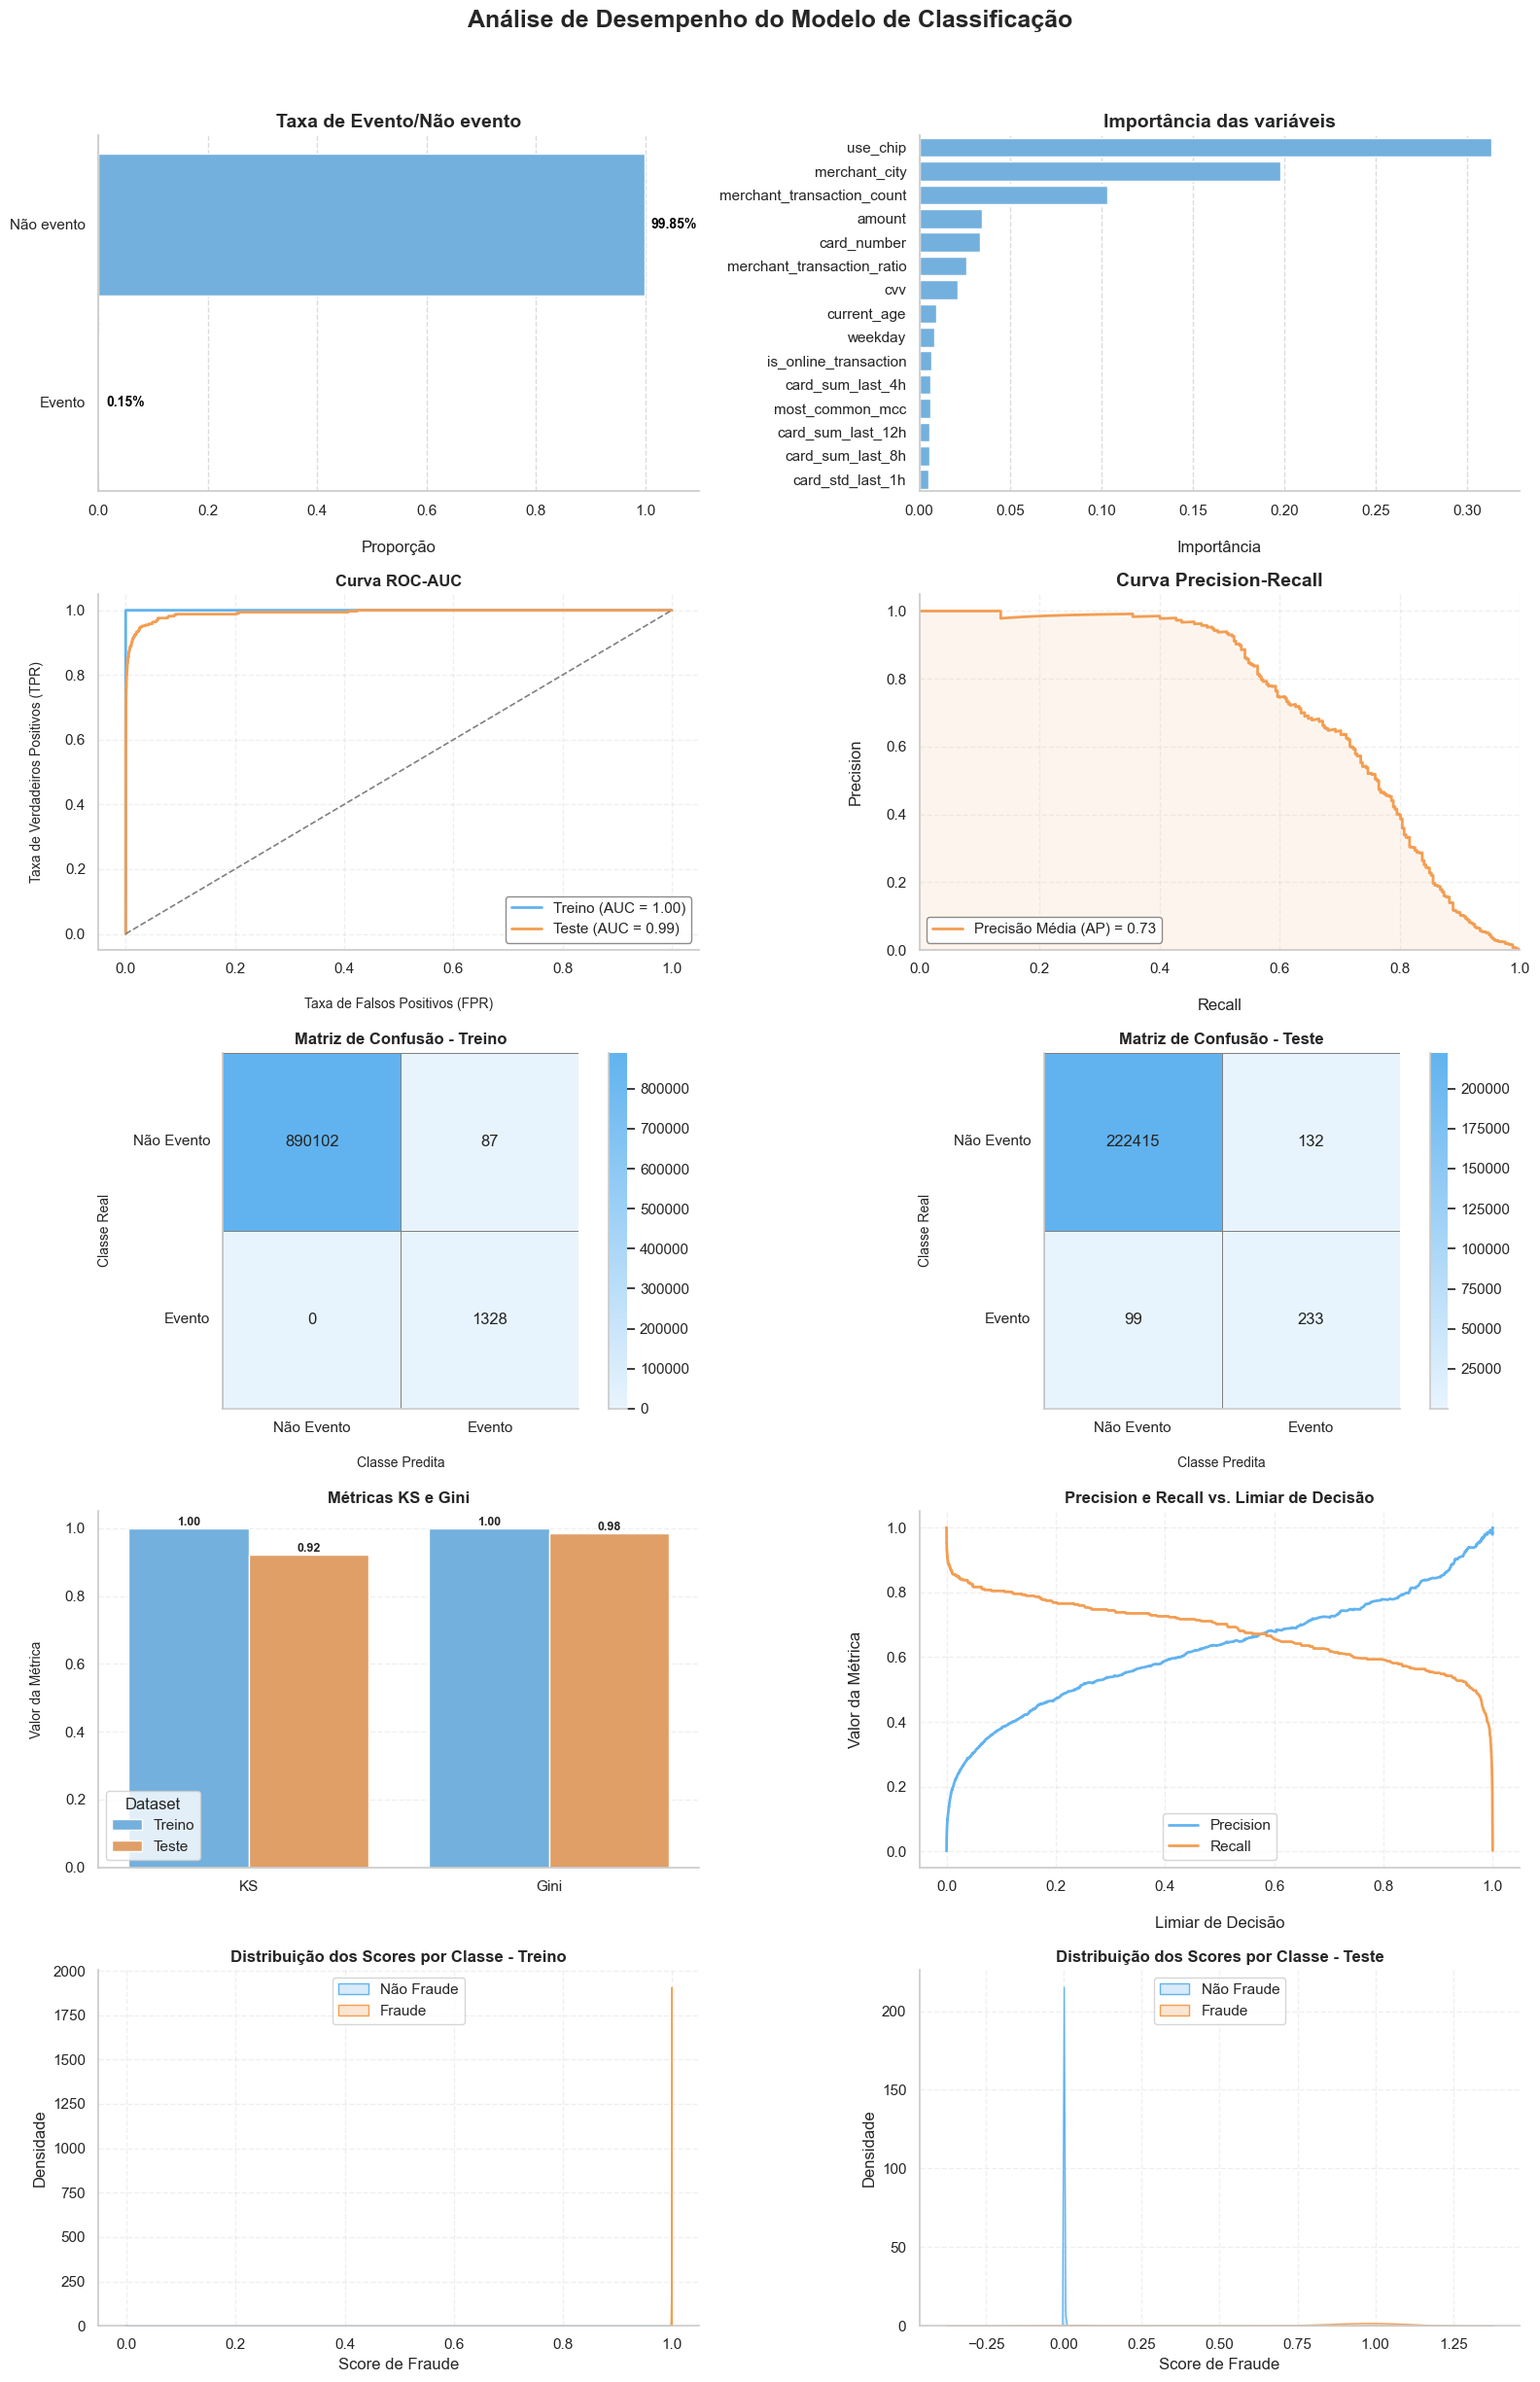

In [37]:
# Recupera os melhores hiperparâmetros encontrados pelo Optuna
params = study.best_params

# Obtém os nomes das features
features = X_train.columns

# Inicializa o modelo XGBoost com os melhores hiperparâmetros ajustados
best_algorithm_tuned = XGBClassifier(**params, random_state=42, scale_pos_weight=scale_pos_weight,
                                      eval_metric='logloss', use_label_encoder=False, 
                                      verbosity=0, n_jobs=-1)

# Treina o modelo com os dados já pré-processados
best_algorithm_tuned.fit(X_train_processed, y_train)

# Plota as métricas de desempenho do melhor modelo ajustado
plot_metrics(best_algorithm_tuned, X_train_processed, y_train, X_test_processed, y_test, features)

### 5.3. Avaliação do modelo com a alteração de thresholds

In [38]:
def evaluate_model_thresholds(model, X_test, y_test, limit_min=0.5):
    '''
    Avalia um modelo de classificação em conjunto de dados desbalanceado usando diferentes thresholds.

    :param model: estimador
        Modelo treinado com o método predict_proba.
    :param X_test: DataFrame 
        Features do conjunto de teste
    :param y_test: np.ndarray
        Rótulos verdadeiros do conjunto de teste
    :param limit_min: float, default=0.5
        Valor mínimo a ser garantido para precisão ou recall
        
    :return: dict
        Dicionário com as predições: padrão, f1, precision custom e recall custom
    '''
    
    # Probabilidades previstas
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Predições com threshold padrão de 0.5
    y_pred = model.predict(X_test)

    # Métricas no threshold padrão
    print('\n🔶 Relatório com threshold padrão (0.5):\n')
    print(classification_report(y_test, y_pred, zero_division=0, digits=3))
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred_proba):.5f}')
    print(f'PR AUC (Average Precision): {average_precision_score(y_test, y_pred_proba):.5f}')

    # Curva Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    precision = precision[:-1]      # Remove o último valor para alinhar com os thresholds
    recall = recall[:-1]            # Remove o último valor para alinhar com os thresholds
    thresholds = thresholds[:-1]    # Remove o último valor para alinhar com precision e recall

    # F1-score em cada threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    idx_best_f1 = np.argmax(f1_scores)
    best_f1_threshold = thresholds[idx_best_f1]

    print(f'\nMelhor F1-score na curva PR: {f1_scores[idx_best_f1]:.5f}')
    print(f'Threshold que otimizou o F1-score: {best_f1_threshold:.5f}\n')

    y_pred_best_f1 = (y_pred_proba >= best_f1_threshold).astype(int)
    print(f'🔶 Relatório com threshold do melhor F1-score ({best_f1_threshold:.5f}):\n')
    print(classification_report(y_test, y_pred_best_f1, zero_division=0, digits=3))
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred_best_f1):.5f}')
    print(f'PR AUC (Average Precision): {average_precision_score(y_test, y_pred_best_f1):.5f}')

    # Maior recall mantendo precision ≥ limit_min
    valid_recall = [(t, p, r) for t, p, r in zip(thresholds, precision, recall) if p >= limit_min]
    t_high_recall = max(valid_recall, key=lambda x: x[2], default=(None, None, None))

    # Maior precision mantendo recall ≥ limit_min
    valid_precision = [(t, p, r) for t, p, r in zip(thresholds, precision, recall) if r >= limit_min]
    t_high_precision = max(valid_precision, key=lambda x: x[1], default=(None, None, None))

    # Relatórios personalizados
    if t_high_precision[0] is not None:
        y_pred_custom_precision = (y_pred_proba >= t_high_precision[0]).astype(int)
        print(f'\n🔶 Threshold com maior Precision (Recall ≥ {limit_min}): {t_high_precision[0]:.5f} | Precision: {t_high_precision[1]:.2f} | Recall: {t_high_precision[2]:.2f}\n')
        print(classification_report(y_test, y_pred_custom_precision, zero_division=0, digits=3))
    else:
        print(f'\n🔺 Nenhum threshold com Recall ≥ {limit_min} foi encontrado para Precision máxima.')

    if t_high_recall[0] is not None:
        y_pred_custom_recall = (y_pred_proba >= t_high_recall[0]).astype(int)
        print(f'\n🔶 Threshold com maior Recall (Precision ≥ {limit_min}): {t_high_recall[0]:.5f} | Recall: {t_high_recall[2]:.2f} | Precision: {t_high_recall[1]:.2f}\n')
        print(classification_report(y_test, y_pred_custom_recall, zero_division=0, digits=3))
    else:
        print(f'\n🔺 Nenhum threshold com Precision ≥ {limit_min} foi encontrado para Recall máximo.')
        
    return {
        'default': y_pred,
        'f1': y_pred_best_f1,
        'precision': y_pred_custom_precision,
        'recall': y_pred_custom_recall,
        'proba': y_pred_proba,
        'thresholds': {
            'f1': best_f1_threshold,
            'precision': t_high_precision[0],
            'recall': t_high_recall[0]
        }
    }


In [39]:
# Executa a avaliação e armazena as predições
results = evaluate_model_thresholds(best_algorithm_tuned, X_test_processed, y_test, limit_min=0.689)


🔶 Relatório com threshold padrão (0.5):

              precision    recall  f1-score   support

           0      1.000     0.999     0.999    222547
           1      0.638     0.702     0.669       332

    accuracy                          0.999    222879
   macro avg      0.819     0.851     0.834    222879
weighted avg      0.999     0.999     0.999    222879

ROC AUC: 0.99236
PR AUC (Average Precision): 0.72824

Melhor F1-score na curva PR: 0.67387
Threshold que otimizou o F1-score: 0.87646

🔶 Relatório com threshold do melhor F1-score (0.87646):

              precision    recall  f1-score   support

           0      0.999     1.000     1.000    222547
           1      0.839     0.563     0.674       332

    accuracy                          0.999    222879
   macro avg      0.919     0.782     0.837    222879
weighted avg      0.999     0.999     0.999    222879

ROC AUC: 0.78155
PR AUC (Average Precision): 0.47297

🔶 Threshold com maior Precision (Recall ≥ 0.689): 0.52994 

In [40]:
def plot_confusion_matrices(y_test, y_pred_default, y_pred_f1, y_pred_precision, y_pred_recall):
    '''
    Plota quatro matrizes de confusão comparando diferentes thresholds de decisão 
    para um modelo de classificação em um problema desbalanceado.

    :param y_test: np.ndarray
        Rótulos verdadeiros do conjunto de teste.
    :param y_pred_default: np.ndarray
        Predições com threshold padrão de 0.5.
    :param y_pred_f1: np.ndarray
        Predições com threshold otimizado para o melhor F1-score.
    :param y_pred_precision: np.ndarray
        Predições com threshold ajustado para máxima precisão com recall ≥ limite mínimo.
    :param y_pred_recall: np.ndarray
        Predições com threshold ajustado para máximo recall com precisão ≥ limite mínimo.
    '''

    # Paleta de cores personalizada
    cmap_custom = LinearSegmentedColormap.from_list('custom_blues', ['#e8f4fd', '#61b3ef'])

    # Criação da figura com subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # Lista com as predições e os títulos dos gráficos
    predicoes = [
        (y_pred_default, 'Threshold padrão (0.5)', axs[0, 0]),
        (y_pred_f1, 'Threshold ajustado (F1-score)', axs[0, 1]),
        (y_pred_precision, 'Threshold ajustado (Precision ≥ limite)', axs[1, 0]),
        (y_pred_recall, 'Threshold ajustado (Recall ≥ limite)', axs[1, 1])
    ]

    # Loop para desenhar cada matriz de confusão
    for y_pred, titulo, ax in predicoes:
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap_custom,
                    annot_kws={'size': 16}, cbar_kws={'label': ''},
                    linewidths=0.5, linecolor='gray', square=True, ax=ax)
        ax.set_title(titulo, fontsize=12, fontweight='bold')
        ax.set_xlabel('\nClasse Predita')
        ax.set_ylabel('Classe Real\n')
        ax.set_xticklabels(['Não Evento', 'Evento'])
        ax.set_yticklabels(['Não Evento', 'Evento'], rotation=90)

    plt.tight_layout()
    plt.show()


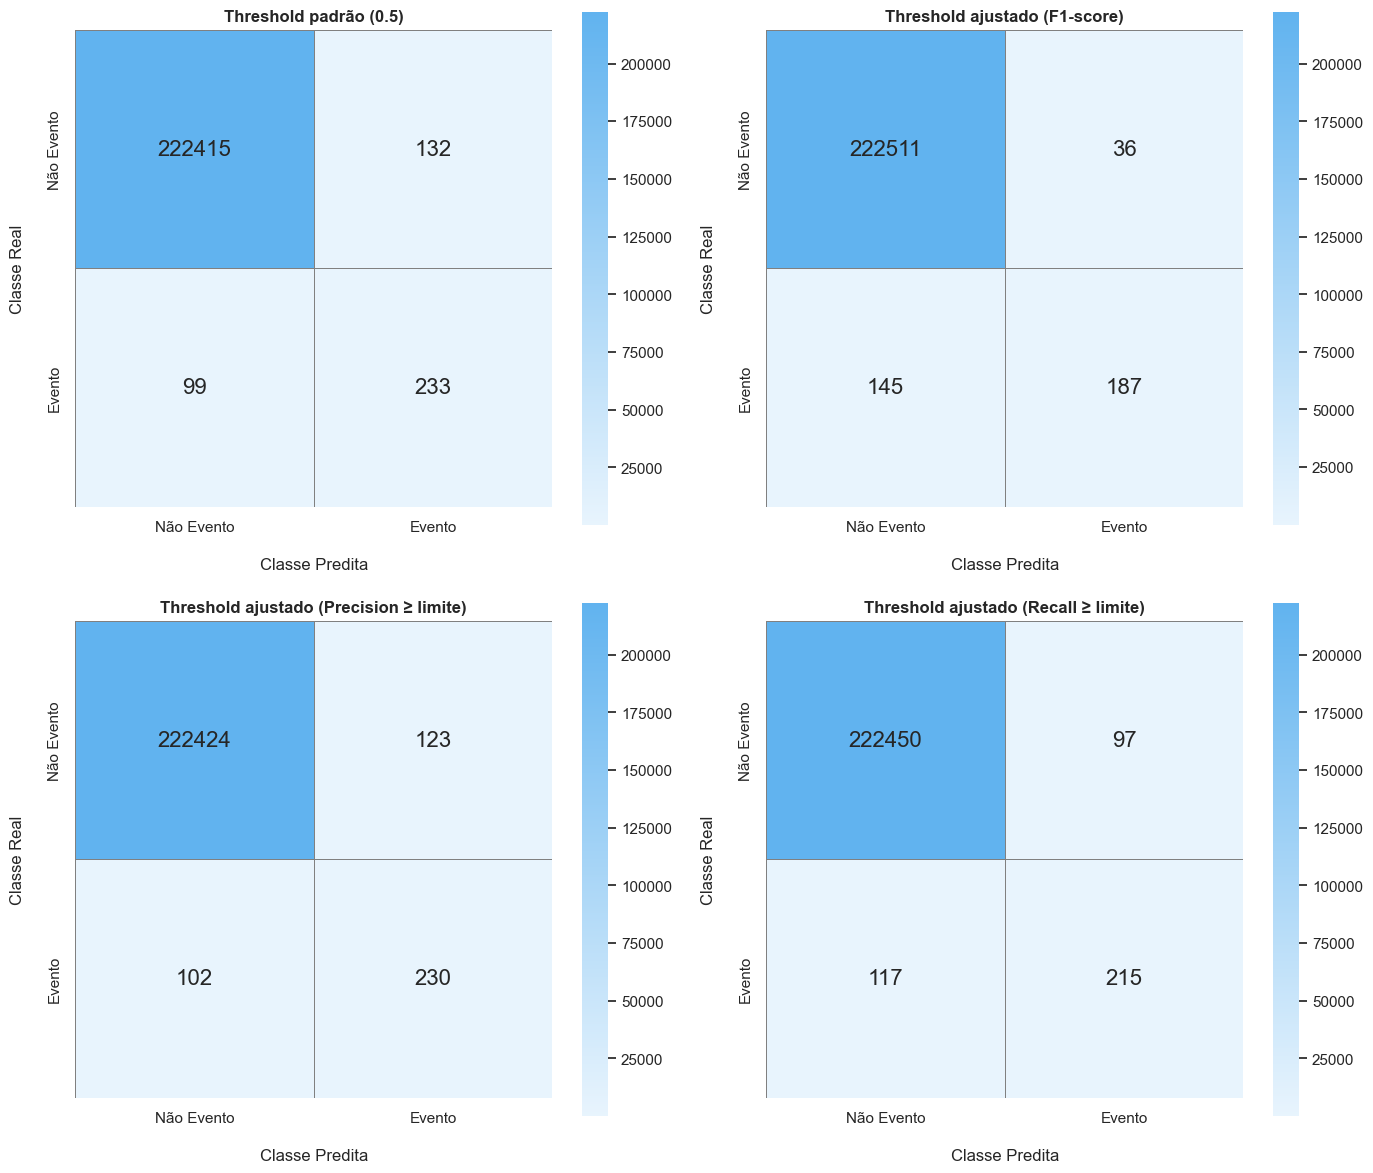

In [41]:
# Passa as predições para a função de plot
plot_confusion_matrices(y_test, results['default'], results['f1'], results['precision'], results['recall'])

## 6. Análise e desempenho do modelo com N variáveis

### 6.1. Visualização das N variáveis mais importantes

In [42]:
# Obtendo a importância das variáveis do modelo ajustado
importances = best_algorithm_tuned.feature_importances_

# Contando a quantidade de variáveis que entraram no modelo ajustado
qtd_vars_model = (importances > 0).sum()

print(f'Quantidade de variáveis que entraram no modelo ajustado: {qtd_vars_model}')


Quantidade de variáveis que entraram no modelo ajustado: 140


In [43]:
def plot_feature_importance(model, features, top_n_features=10):
    '''
    Exibe gráfico de importância das variáveis de um modelo com atributo `feature_importances_`.

    :param model: estimator
        Estimador previamente treinado com o atributo `feature_importances_`.
    :param features: list or array-like
        Lista com os nomes das variáveis utilizadas no modelo.
    :param top_n_features: int, default=10
        Número de variáveis mais importantes a serem exibidas no gráfico.
    '''

    # Verifica se o modelo possui o atributo necessário
    if not hasattr(model, 'feature_importances_'):
        raise ValueError('O modelo fornecido não possui o atributo `feature_importances_`.')

    # Obtém e ordena as importâncias
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n_features]
    
    # Seleciona as top_n_features
    top_features = np.array(features)[indices]
    top_importances = importances[indices]

    # Cria o gráfico
    plt.figure(figsize=(12, 6))
    sns.barplot(y=top_features, x=top_importances, palette=['#61b3ef'])

    plt.title(f'Importância das {top_n_features} variáveis', fontsize=14, fontweight='bold')
    plt.xlabel('\nImportância', fontsize=12)
    plt.ylabel('Variável', fontsize=12)

    # Adiciona os valores numéricos ao lado das barras
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=10)

    sns.despine()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


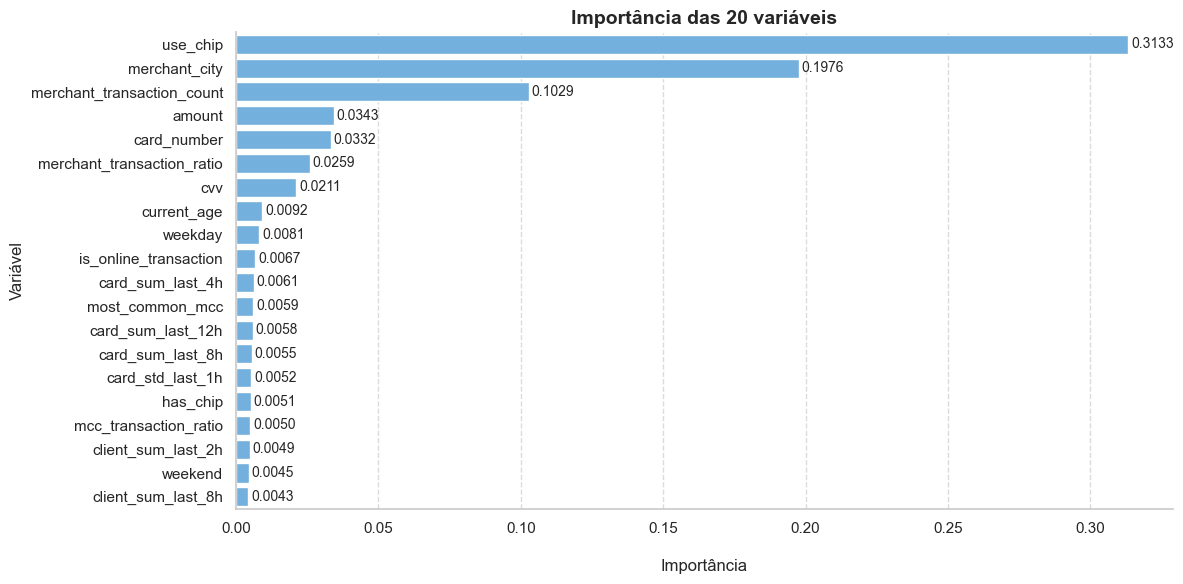

In [44]:
# Exibe o gráfico de importância das variáveis do modelo ajustado
plot_feature_importance(best_algorithm_tuned, features, top_n_features=20)


### 6.2. Avaliação do modelo com N variáveis mais importantes

In [ ]:
def evaluate_model_summary(model, X_train, y_train, X_test, y_test, feature_names, n_features_list):
    '''
    Avalia o desempenho de um modelo usando as N variáveis mais importantes.

    :param model: estimador
        Estimador já treinado com suporte a feature_importances_.
    :param X_train: array ou DataFrame
        Dados de treino com todas as features.
    :param y_train: array
        Rótulos do treino.
    :param X_test: array ou DataFrame
        Dados de teste com todas as features.
    :param y_test: array
        Rótulos do teste.
    :param feature_names: list
        Lista com os nomes das variáveis (deve corresponder a X_train.columns).
    :param n_features_list: list
        Lista com os valores de N a testar (ex: [5, 10, 20]).
        
    :return: DataFrame
        Tabela com as métricas de avaliação para cada valor de N.
    '''

    resultados = []

    # Verifica se o modelo possui o atributo necessário
    if not hasattr(model, 'feature_importances_'):
        raise ValueError('O modelo fornecido não possui o atributo `feature_importances_`.')

    # Garante que os dados estejam em formato DataFrame com colunas nomeadas
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train, columns=feature_names)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=feature_names)

    # Obtém e ordena as importâncias
    importances = model.feature_importances_
    indices_ordenados = np.argsort(importances)[::-1]  # Mais importantes primeiro

    # Loop para testar o modelo com diferentes quantidades de variáveis
    for n in n_features_list:
        
        # Seleciona os N nomes das variáveis mais importantes
        top_indices = indices_ordenados[:n]
        top_features = np.array(feature_names)[top_indices].tolist()

        # Cria subconjuntos de treino e teste com as N variáveis mais importantes
        X_train_subset = X_train[top_features]
        X_test_subset = X_test[top_features]

        # Clona o modelo original e o treina novamente usando apenas as N variáveis selecionadas
        modelo_n = model.__class__(**model.get_params())
        modelo_n.fit(X_train_subset, y_train)

        # Score da primeira instância
        start = time.time()
        score_fraude = modelo_n.predict_proba(X_test_subset.iloc[[0]])[:, 1][0]
        tempo_pred = time.time() - start

        # Predições e métricas
        y_pred = modelo_n.predict(X_test_subset)
        y_proba = modelo_n.predict_proba(X_test_subset)[:, 1]

        auc = roc_auc_score(y_test, y_proba)
        gini = 2 * auc - 1
        ks = ks_2samp(y_proba[y_test == 1], y_proba[y_test == 0]).statistic

        resultados.append({
            'Top N features': n,
            'Score fraude': score_fraude,
            'Tempo de predição': tempo_pred,
            'Acurácia': accuracy_score(y_test, y_pred),
            'Precisão': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC AUC': auc,
            'PR AUC': average_precision_score(y_test, y_proba),
            'KS': ks,
            'Gini': gini
        })

    return pd.DataFrame(resultados)



In [46]:
# Lista de N variáveis a serem testadas
n_features_list = [15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 140]

# Avalia o modelo com as N variáveis mais importantes
df_results = evaluate_model_summary(
    model=best_algorithm_tuned,
    X_train=X_train_processed,
    y_train=y_train,
    X_test=X_test_processed,
    y_test=y_test,
    feature_names=features,
    n_features_list=n_features_list
)

display(df_results)


,Top N features,Score fraude,Tempo de predição,Acurácia,Precisão,Recall,F1-Score,ROC AUC,PR AUC,KS,Gini
0,15,0.000002,0.002992,0.997613,0.345201,0.671687,0.456033,0.990960,0.646323,0.907403,0.981920
1,20,0.000001,0.001995,0.998165,0.427221,0.680723,0.524971,0.993829,0.683450,0.922086,0.987657
2,25,0.000002,0.001995,0.998694,0.549878,0.680723,0.608345,0.993262,0.707727,0.923475,0.986524
3,30,0.000001,0.002157,0.998757,0.570694,0.668675,0.615811,0.993636,0.708124,0.920857,0.987272
4,35,0.000002,0.002992,0.998703,0.552311,0.683735,0.611036,0.992516,0.711100,0.917892,0.985031
5,40,0.000001,0.004075,0.998789,0.579897,0.677711,0.625000,0.993873,0.716242,0.919294,0.987746
6,45,0.000001,0.003989,0.998807,0.585938,0.677711,0.628492,0.993235,0.719712,0.925916,0.986471
7,50,0.000001,0.003099,0.998676,0.545906,0.662651,0.598639,0.991778,0.699548,0.917001,0.983555
8,60,0.000001,0.004987,0.998829,0.593668,0.677711,0.632911,0.990842,0.718426,0.915545,0.981685
9,70,0.000002,0.003989,0.998874,0.607427,0.689759,0.645980,0.992280,0.727900,0.921698,0.984560


## 7. Tunagem dos hiperparâmetros do modelo com N variáveis

### 7.1. Criando o pipeline de pré-processamento

In [ ]:
# Define o número de variáveis mais importantes a serem exibidas
top_n_features = 80

# Obtém as importâncias das variáveis do modelo ajustado
importances = best_algorithm_tuned.feature_importances_
indices = np.argsort(importances)[::-1][:top_n_features]

# Seleciona as top_n_features e seus nomes
top_features = np.array(features)[indices].tolist()

In [50]:
# Separando as variáveis numéricas e categóricas

numerical_top_features = X_train[top_features].select_dtypes(exclude=[object, 'category']).columns
categorical_top_features = X_train[top_features].select_dtypes(include=[object, 'category']).columns

In [51]:
# Criando o pipeline para as variáveis numéricas
num_pipeline_top_features = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as variáveis categóricas
cat_pipeline_top_features = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder())
])

In [52]:
# Criando o pipeline de pré-processamento que aplica transformações

preprocessor_top_features = ColumnTransformer([
        ('num', num_pipeline_top_features, numerical_top_features),
        ('cat', cat_pipeline_top_features, categorical_top_features)
])
preprocessor_top_features = Pipeline(steps=[('preprocessor', preprocessor_top_features)])

In [47]:
import sys
sys.exit(0)  # Interrompe a execução do script após a definição da função

SystemExit: 0